<a href="https://colab.research.google.com/github/XRater/DUL_2019/blob/hw1/DUL_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pickle
import torch
import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
import matplotlib.pyplot as plt

# Warmup

In [0]:
def sample_data():
  count = 10000
  rand = np.random.RandomState(0)
  a = 0.3 + 0.1 * rand.randn(count)
  b = 0.8 + 0.05 * rand.randn(count)
  mask = rand.rand(count) < 0.5
  samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
  return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [0]:
warmup_data = sample_data()
warmup_data_train, warmup_data_test = train_test_split(warmup_data)

In [5]:
warmup_data_train.shape, warmup_data_test.shape

((7500,), (2500,))

In [0]:
def draw_losses(train_losses, val_losses):
    plt.plot(np.arange(len(train_losses)), train_losses)
    plt.plot(np.arange(len(val_losses)), val_losses)
    plt.legend(('train_loss', 'val_loss'));

In [0]:
def train(model, optimizer, train_loader, test_loader, num_epochs, epoch_rate=1):
  train_losses, val_losses = [], []
  for epoch in range(num_epochs):
    loss, val_loss = 0, 0
    for batch in train_loader:
      optimizer.zero_grad()
      _ = model(batch)
      curr_loss = model.loss
      loss += curr_loss.item()
      curr_loss.backward()
      optimizer.step()

    with torch.no_grad():
      for batch in test_loader:
        _ = model(batch)
        val_loss += model.loss

    train_losses.append(loss / len(train_loader))
    val_losses.append(val_loss / len(test_loader))
    if epoch % epoch_rate == 0:
      print(f"After epoch {epoch} loss is {loss / len(train_loader)} and validation loss is {val_loss / len(test_loader)}")
  return train_losses, val_losses

In [0]:
class WarmupModel(nn.Module):

  def __init__(self, input_size):
    super(WarmupModel, self).__init__()
    self.input_size = input_size
    self.thetas = nn.Parameter(torch.ones(input_size))

  def get_probs(self):
    exps = self.thetas.exp()
    return exps / exps.sum()

  def forward(self, X):
    probs = self.get_probs()[X]
    self.loss = -probs.log2().mean()
    return probs


In [0]:
def run_warmupModel(train_data, test_data):
  batch_size = 200
  num_epochs = 300

  model = WarmupModel(100)
  optimizer = torch.optim.Adam(model.parameters())
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
  train_losses, val_losses = train(model, optimizer, train_loader, test_loader, num_epochs, epoch_rate=30)

  draw_losses(train_losses, val_losses)
  return model

After epoch 0 loss is 6.623973909177278 and validation loss is 6.6039204597473145
After epoch 30 loss is 5.993715236061497 and validation loss is 6.0038557052612305
After epoch 60 loss is 5.865179664210269 and validation loss is 5.886895179748535
After epoch 90 loss is 5.8356383850699975 and validation loss is 5.8596014976501465
After epoch 120 loss is 5.826956799155788 and validation loss is 5.850234031677246
After epoch 150 loss is 5.821518396076403 and validation loss is 5.846882343292236
After epoch 180 loss is 5.8188418965590625 and validation loss is 5.845678329467773
After epoch 210 loss is 5.817588755958958 and validation loss is 5.845209121704102
After epoch 240 loss is 5.818955597124602 and validation loss is 5.845367431640625
After epoch 270 loss is 5.815705123700593 and validation loss is 5.845427989959717


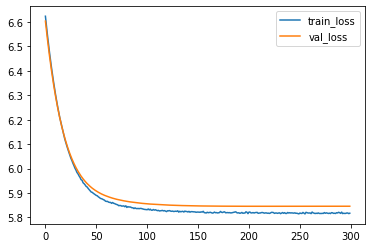

In [10]:
warmup_model = run_warmupModel(warmup_data_train, warmup_data_test)

In [0]:
def draw_warmup_results(model, data, size=1000):
  probs = model.get_probs().detach().numpy()
  plt.figure(1)
  plt.bar(np.arange(100), probs)
  plt.figure(2)
  plt.bar(np.arange(100), np.histogram(data[:size], bins=100, range=(0,100))[0]);

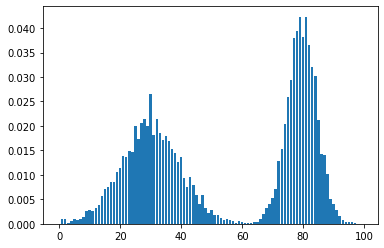

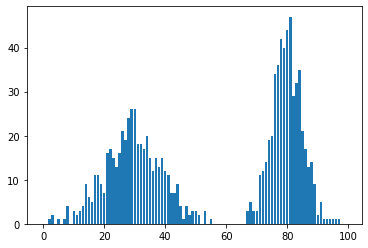

In [12]:
draw_warmup_results(warmup_model, warmup_data)

# Two-dimensional data

In [14]:
from google.colab import drive
drive.mount('/content/drive')

def load_data():
  dataset_path = '/content/drive/My Drive/dataset/distribution.npy'
  dataset = np.load(dataset_path)

  return dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


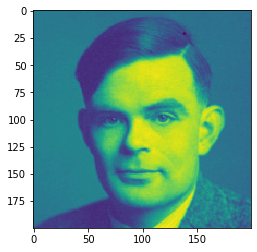

In [15]:
distribution = load_data()
plt.imshow(distribution);

In [0]:
def generate_data2(N, sz):
  coords = np.indices(dimensions=(sz,sz)).T 
  indices = np.random.choice(np.arange(sz ** 2), p=distribution.reshape(-1), size=N)
  return coords.reshape(-1, 2)[indices]

In [0]:
data2 = generate_data2(100000, 200)
data2_train, data2_test = train_test_split(data2, train_size=0.8)

In [18]:
data2_train.shape, data2_test.shape

((80000, 2), (20000, 2))

In [0]:
class MLPModel(nn.Module):

    def __init__(self, data_size):
        super(MLPModel, self).__init__()
        self.data_size = data_size
        self.thetas = torch.nn.Parameter(torch.ones(data_size))

        self.model = nn.Sequential(
          nn.Linear(data_size, 400),
          nn.LeakyReLU(),
          nn.Linear(400, data_size),            
        )

    def get_probs(self):
      exps = self.thetas.exp()
      return exps / exps.sum()

    def forward(self, X):
        xs, ys = X[:, 0], X[:, 1]
        probs_x = self.get_probs()[xs]

        onehot_y = F.one_hot(ys, num_classes=self.data_size).float()
        z = self.model(onehot_y).softmax(dim=1)        
        
        probs_y = z[range(xs.shape[0]), xs]
        probs = probs_x * probs_y
        self.loss = -probs.log2().mean()
        return probs

In [0]:
def run_MLPModel(train_data, test_data):
  batch_size = 200
  num_epochs = 20

  model = MLPModel(200)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
  train_losses, val_losses = train(model, optimizer, train_loader, test_loader, num_epochs)

  draw_losses(train_losses, val_losses)
  return model

After epoch 0 loss is 15.273949217796325 and validation loss is 15.261351585388184
After epoch 1 loss is 15.24732414007187 and validation loss is 15.244414329528809
After epoch 2 loss is 15.232846801280976 and validation loss is 15.238877296447754
After epoch 3 loss is 15.225220959186554 and validation loss is 15.235466003417969
After epoch 4 loss is 15.218543832302094 and validation loss is 15.232233047485352
After epoch 5 loss is 15.211739451885224 and validation loss is 15.229070663452148
After epoch 6 loss is 15.204713995456695 and validation loss is 15.226123809814453
After epoch 7 loss is 15.197261989116669 and validation loss is 15.223310470581055
After epoch 8 loss is 15.189514451026916 and validation loss is 15.220603942871094
After epoch 9 loss is 15.181536412239074 and validation loss is 15.217855453491211
After epoch 10 loss is 15.173426849842071 and validation loss is 15.215511322021484
After epoch 11 loss is 15.16530133485794 and validation loss is 15.213406562805176
Afte

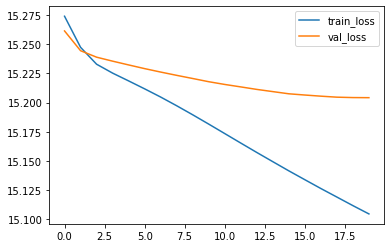

In [21]:
mlpModel = run_MLPModel(data2_train, data2_test)

In [0]:
def show_data2(model, sz):
  coords = np.indices(dimensions=(sz,sz)).T
  predicted = model(torch.tensor(coords.reshape(-1, 2))).reshape(sz, sz)
  plt.imshow(predicted.detach().numpy());

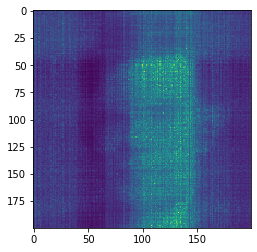

In [32]:
show_data2(mlpModel, 200)

# MADE

In [0]:
class MaskedLayer(nn.Module):
    def __init__(self, mask):
        super(MaskedLayer, self).__init__() 
        self.W = nn.Parameter(torch.Tensor(mask.shape))
        self.b = nn.Parameter(torch.Tensor(mask.shape[1]))
        nn.init.xavier_normal_(self.W)
        nn.init.uniform_(self.b)
        self.mask = mask

    def forward(self, X):
        return X @ (self.W * self.mask) + self.b

class MADEModel(nn.Module):
    def __init__(self, input_size):
        super(MADEModel, self).__init__()
        self.input_size = input_size
        
        in_size = 2 * input_size
        out_size = 3 * input_size

        m = torch.randint(low=1, high=in_size, size=(out_size,))
        ind = torch.randperm(in_size) + 1
        MW = ind[:, None] <= m[None, :]
        MV = m[:, None] < ind[None, :]

        self.model = nn.Sequential(
            MaskedLayer(MW),
            nn.ReLU(),
            MaskedLayer(MV)
        )

    def forward(self, X):
        xs, ys = X[:, 0], X[:, 1]
        
        onehot_x = F.one_hot(xs, num_classes=self.input_size).float()
        onehot_y = F.one_hot(ys, num_classes=self.input_size).float()
        onehot = torch.cat([onehot_x, onehot_y], dim=1)

        z = self.model(onehot).view(-1, 2, self.input_size)
        z = z.softmax(dim=2)
        z_x, z_y = z[:,0], z[:, 1]
        probs_x = z_x[range(xs.shape[0]), xs]
        probs_y = z_y[range(ys.shape[0]), ys]
        probs = probs_x * probs_y
        self.loss = -probs.log2().mean()

        return probs

In [0]:
def run_MADEModel(train_data, test_data):
  batch_size = 512
  num_epochs = 30

  model = MADEModel(200)
  optimizer = torch.optim.Adam(model.parameters())
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
  train_losses, val_losses = train(model, optimizer, train_loader, test_loader, num_epochs, epoch_rate=2)

  draw_losses(train_losses, val_losses)
  return model

After epoch 0 loss is 15.258543719151977 and validation loss is 15.130361557006836
After epoch 2 loss is 13.077240512629224 and validation loss is 12.096409797668457
After epoch 4 loss is 9.492419801699887 and validation loss is 8.905244827270508
After epoch 6 loss is 7.326170247071867 and validation loss is 7.034108638763428
After epoch 8 loss is 6.000746651060262 and validation loss is 5.854797840118408
After epoch 10 loss is 5.105543075853093 and validation loss is 5.074101448059082
After epoch 12 loss is 4.449393885910132 and validation loss is 4.494041919708252
After epoch 14 loss is 3.9448481289444457 and validation loss is 4.014523506164551
After epoch 16 loss is 3.5456941887071936 and validation loss is 3.662640333175659
After epoch 18 loss is 3.206188768338246 and validation loss is 3.3689308166503906
After epoch 20 loss is 2.9270420621155173 and validation loss is 3.0978457927703857
After epoch 22 loss is 2.693800687789917 and validation loss is 2.889268636703491
After epoch 

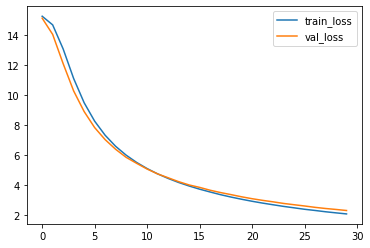

In [321]:
madeModel = run_MADEModel(data2_train, data2_test)

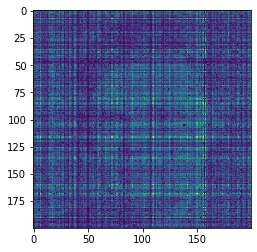

In [322]:
show_data2(madeModel, 200)